<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/06.01-Fitting-First-Order-plus-Time-Delay-to-Step-Response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting First Order plus Time Delay to Step Response

>N.B.: Parts of this notebook were taken from [here](https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/03.04-Fitting-First-Order-plus-Time-Delay-to-Step-Response.ipynb#scrollTo=-9RAUuaUqrKK).

## Summary

Linear first order plus time delay (FOPTD) models are often good approximations to process dynamics for process control applications. This notebook demonstrates the fitting of FOPTD models to step response data.

## Initializations

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
!pip install control
import control
from scipy.optimize import minimize

     |████████████████████████████████| 339 kB 5.3 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=0069bf87cbbd9fb8bcc9884d21357599d482105d4ca83000961159dbbc0a11b3
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control


## First Order plus Time Delay Models

### First Order Models

A linear first-order plus time-delay model is a good approximation for many process control applications. Assume the manipulated process input, $u$, and measured process output, $y$, are initially at steady-state $u_0, y_0$.  

Without loss of generality, the response of a linear first-order system without time-delay can be written as a differential equation

$$\tau\frac{d(y-y_0)}{dt} + (y-y_0) = K(u-u_0)$$

or

$$\tau\frac{dy}{dt} + (y-y_0) = K(u-u_0)$$

At time $t_0$, the input $u$ is changed to a new constant value $u_\infty$. Provided the system is stable (i.e, $\tau \geq 0$), the new steady state value of $y$ will be 

$$y_\infty = y_0 + K(u_\infty - u_0)$$


The solution to the differential equation can be written in a number of useful forms.

\begin{align*}
y(t) & = y_0 + K(u_\infty - u_0) (1 - e^{-(t-t_0)/\tau)}) \\
\\
& = y_0 + (y_\infty - y_0) (1 - e^{-(t-t_0)/\tau)}) \\
\\
& = y_\infty + (y_0 - y_\infty)e^{-(t-t_0)/\tau)}
\end{align*}

### Time Delay

Chemical processes are frequently encumbered with time delays associated with the transport of materials, chemical measurement, or simply sluggish response to control inputs. A pure time delay is modeled by a single parameter, $t_d$, such that 

$$y(t) = u(t-t_d)$$

### First Order plus Time Delay (FOPTD) 

If we add the time delay feature to the first order process described above, then for $ t \geq t_d + t_0 $

\begin{align*}
y(t) & = y_0 + K(u_\infty - u_0) (1 - e^{-(t-t_d - t_0)/\tau)}) \\
\\
& = y_0 + (y_\infty - y_0) (1 - e^{-(t-t_d-t_0)/\tau)}) \\
\\
& = y_\infty + (y_0 - y_\infty)e^{-(t-t_d-t_0)/\tau)}
\end{align*}

and $ y(t) = y_0 $ for $ t \lt t_d + t_0 $

### Visualization

First we write a function to compute the response of a first order system with time delay to a unit step input where $u_0 = 0$ and $u_\infty = 1$.  

In [ ]:
def foptd(t, K=1, tau=1, tau_d=0):
    tau_d = max(0,tau_d)
    tau = max(0,tau)
    return np.array([K*(1-np.exp(-(t-tau_d)/tau)) if t >= tau_d else 0 for t in t])

Text(0.5, 1.0, 'FOPTD Step Response')

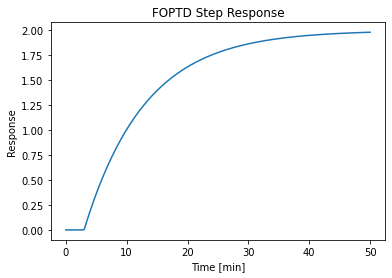

In [ ]:
t = np.linspace(0,50,200)
tau = 10
tau_delay = 3
K = 2

y = foptd(t,K,tau,tau_delay)
plt.plot(t,y)
plt.xlabel('Time [min]')
plt.ylabel('Response')
plt.title('FOPTD Step Response')

## Fitting an FOPTD model

Based on the following FOPTD response for $ t \geq t_d + t_0 $   

$$ y(t) = y_0 + (y_\infty - y_0) (1 - e^{-(t-t_d - t_0)/\tau)}) $$   

the time $ t_x - t_0 $ needed to reach some response $ y_x $ is given by

$$ t_x - t_0 = t_d - \tau \ln \left( 1 - \frac{y_x - y_0}{y_\infty - y_0}\right) $$ 

if we make $ x = \frac{y_x - y_0}{y_\infty - y_0} $ and $t_{xs} = t_x - t_0$, then   

$$ t_{xs} = t_d + \tau f_1(x) $$ 

and

$$ f_1(x) = -\ln(1 - x) $$

Hence, as $t_0$ is known, to obtain $t_d$ and $\tau$ we have to plug the two time values $t_1$ and $t_2$ needed to reach the fractional responses $x_1$ and $x_2$.

\begin{align*}
t_{1s} & =  t_d + \tau f_1(x_1) \\
\\
t_{2s} & =  t_d + \tau f_1(x_2) \\
\end{align*}

Solving the equations for $\tau$ and $t_d$, we have

\begin{align*}
\tau & =  \frac{t_2 - t_1}{f_1(x_2) - f_1(x_1)} \\
\\
t_d & =  t_{2s} - \tau f_1(x_2) \\
\end{align*}

which can rewritten to   

\begin{align*}
\tau & =  a_1(t_{2s} - t_{1s}) \\
\\
t_d & =  b_1 t_{1s} + (1 - b_1)t_{2s} \\
\end{align*}

where 

\begin{align*}
a_1 & =  \frac{1}{f_1(x_2) - f_1(x_1)} \\
\\
b_1 & =  a_1 f_1(x_2) \\
\end{align*}

Several methods were proposed based on these relationships and the respective points $x_1$ and $x_2$ for each method are given below.

\begin{align}
\begin{array}{ccc}
\mbox{Method} & \mbox{$x_1$%} & \mbox{$x_2$%}\\
\mbox{Smith} & \mbox{28.3} & \mbox{63.2} \\
\mbox{SK} & \mbox{35.3} & \mbox{85.3}\\
\mbox{Strejc} & \mbox{20.0} & \mbox{80.0}\\
\mbox{Vítečková} & \mbox{33.0} & \mbox{70.0}
\end{array}
\end{align}

In [ ]:
# Let's calculate the a1 and b1 values for each method
K = 100
y = foptd(t,K,tau,tau_delay)
pcts = np.array([[28.3, 63.2], [35.3, 85.3], [20.0, 80.0], [33.0, 70.0]])
times = np.zeros(shape=pcts.shape)
ab = times
for k, pct in enumerate(pcts):
  times[k] = np.interp(pct, y, t)
  f1 = -np.log(1-pct/100)
  a1 = 1/(f1[1] - f1[0])
  ab[k] = [a1, a1*f1[1]]
ab

array([[1.49926633, 1.49877508],
       [0.67480312, 1.29381534],
       [0.72134752, 1.16096405],
       [1.24456245, 1.49841934]])

### Sample Problem Statement

A distillation column is initially at steady state where the steam flow to the reboiler is 110 kg/hr and the vapor phase mole fraction of the volatile compound is 0.87.  At t = 60 min, the steam flow is raised to 120 kg/hr. The vapor phase mole fraction increases as shown in the following chart. 

Text(0.5, 1.0, 'Vapor mole fraction response to 10 kg/hr increase in reboiler steam flow')

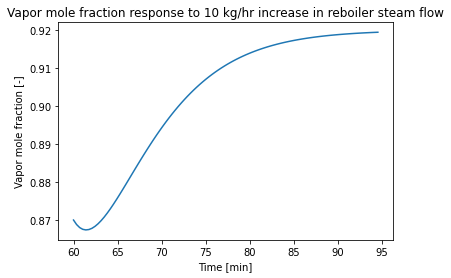

In [ ]:
# create the hypothetical problem data
t,delta_y = control.step_response(0.05*control.tf([-2, 1],[25, 10, 1]))
y0 = 0.87
y = y0 + delta_y
t0 = 60
t = t + t0

plt.plot(t,y)
plt.xlabel('Time [min]')
plt.ylabel('Vapor mole fraction [-]')
plt.title('Vapor mole fraction response to 10 kg/hr increase in reboiler steam flow')

The problem task is to fit a FOPTD model to this experimental test in order to obtain an approximation of the process reaction curve transfer function ($G_{PRC} = G_a G_p G_m$), assuming the following ranges:

- Reboiler steam flow (AO valve): 0 to 220 kg/h
- Vapor composition sensor (direct action): 0.5 to 1.0 mole fraction
- Control loop transmission signal: 4 to 20 mA

### Step 1. Calculate the steady state gain   

The steady state gain could be calculated using the equation below:

\begin{align*}
K & = K_a K_p K_m \\
\\
K & = \left(\frac{u_{max} - u_{min}}{p_{max} - p_{min}} \right) \left( \frac{y_\infty - y_0}{u_\infty - u_0} \right) \left( \frac{y_{m,max} - y_{m,min}}{y_{max} - y_{min}} \right)
\end{align*}


In [ ]:
K = (220 - 0)/(20 - 4)*(y[-1] - y[0])/(120 - 110)*(20 - 4)/(1 - 0.5)
print('K = {:.2f} mA/mA'.format(K))

K = 2.18 mA/mA


### Step 2. Shift and scale the experimental data to correspond to a unit step input at time t =  0.

The first step is to scale the experimental data to fit the framework of an FOPTD model. This generally involves three steps:

* Shift the time scale to t = 0 corresponds to the start of the experiment.

$$ t_s = t - t_0$$

* Shift the response so y = 0 is the initial steady state
* Rescale the response to percentage of maximum change

$$ y_s = 100\frac{y(t) - y_0}{y_\infty - y_0}$$

Text(0.5, 1.0, 'Shifted and Scaled Data')

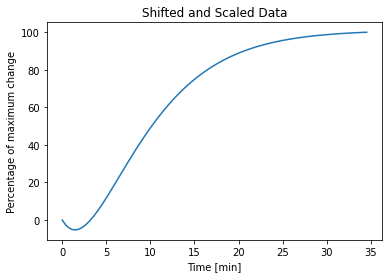

In [ ]:
ts = t - t[0]
ys = 100*(y - y[0])/(y[-1] - y[0])

plt.plot(ts, ys)
plt.xlabel('Time [min]')
plt.ylabel('Percentage of maximum change')
plt.title('Shifted and Scaled Data')

### Step 3. Obtain the times $t_{1s}$ and $t_{2s}$ that response takes to reach $x_1$% and $x_2$%

In [ ]:
times = np.zeros(shape=pcts.shape)
for k, pct in enumerate(pcts):
  times[k] = np.interp(pct, ys, ts)

### Step 4. Obtain the time constant and the dead time values
The values of the time constant and the dead time depend on the process curve identification method and are given below.   

\begin{align}
\begin{array}{ccc}
\mbox{Method} & \mbox{$\tau$} & \mbox{$t_d$}\\
\mbox{Smith} & \mbox{$1.50(t_{63.2s} - t_{28.3s})$} & \mbox{$1.50t_{28.3s} - 0.50t_{63.2s}$}\\
\mbox{SK} & \mbox{$0.675(t_{85.3s} - t_{35.3s})$} & \mbox{$1.29t_{35.3s} - 0.29t_{85.3}$}\\
\mbox{Strejc} & \mbox{$0.721(t_{80.0s} - t_{20.0s})$} & \mbox{$1.161t_{20.0s} - 0.161t_{80.0s}$}\\
\mbox{Vítečková} & \mbox{$1.245(t_{70.0s} - t_{33.0s})$} & \mbox{$1.498t_{33.0s} - 0.498t_{70.0s}$}
\end{array}
\end{align}

In [ ]:
pars = np.zeros(shape=times.shape)
for k, time in enumerate(times):
  pars[k] = [ ab[k][0]*(time[1] - time[0]), ab[k][1]*time[0] + (1 - ab[k][1])*time[1] ]
pars

array([[7.89750298, 4.50198661],
       [6.96234206, 5.01422723],
       [7.49883588, 4.39214219],
       [7.55364616, 4.71608477]])

### Step 5. Compare the FOPTD approximation methods   

For a given list of times $t$ and parameters $K$, $\tau$, and $\tau_d$, the `foptd` returns the response of an FOPTD system to a unit change in input at $t = 0$.

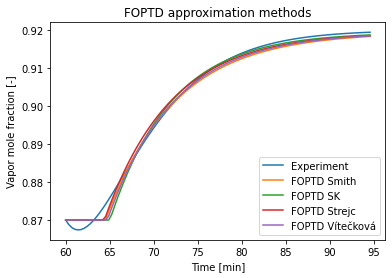

In [ ]:
def foptd(t, K=1, tau=1, t_d=0):
    tau_d = max(0,t_d)
    tau = max(0,tau)
    return np.array([K*(1-np.exp(-(t-t_d)/tau)) if t >= t_d else 0 for t in t])

methods = ['FOPTD Smith', 'FOPTD SK', 'FOPTD Strejc', 'FOPTD Vítečková']
plt.plot(t,y)
#print('K = {:.2f} mA/mA'.format(K))
for k, par in enumerate(pars):
  z = foptd(ts, 1, par[0], par[1])
  ypred = y[0] + z*(y[-1] - y[0])
  plt.plot(t,ypred)
  #print('{:} : tau = {:.2f} and t_d = {:.2f}'.format(methods[k], pars[k][0], pars[k][1]))
plt.xlabel('Time [min]')
plt.ylabel('Vapor mole fraction [-]')
plt.title('FOPTD approximation methods')
plt.legend(['Experiment']+methods)

Ok, it sounds good! But, how about trying another approach using numerical optimization to find the best FOPTD approximation to the experiment data?

We will do it by taking the following steps.

### Step 1. Create a function to measure the error between an FOPTD model and the experimental data.

Let's called the step response of the fitted model to be $\hat{y}_s$. We seek to minimize

$$\min_{K,\tau,\tau_d} \int_0^T \|\hat{y}_s - y_s\|\,dt$$

for some suitable norm $\|\cdot\|$.  A common choice of norm for process control is the absolute value of the difference called Integral Absolute Error (IAE)

$$\text{IAE} = \min_{K,\tau,\tau_d} \int_0^T |\hat{y}_s - y_s|\,dt$$

The advantage of IAE over other choices of norms is that it tends to be more robust with respect to larger errors.

In [ ]:
def err(X,t,y):
    K,tau,t_d = X
    z = foptd(t,K,tau,t_d)
    iae = sum(abs(z-y))*(max(t)-min(t))/len(t)
    return iae

X = [100,10,3]
err(X,ts,ys)

173.7849675363515

### Step 2. Use scipy.optimize.minimize() to find the best fitting FOPTD model.

In [ ]:
K,tau,t_d = minimize(err,X,args=(ts,ys)).x

print('K = {:.5f}'.format(K))
print('tau = {:.2f}'.format(tau))
print('t_d = {:.2f}'.format(t_d))

K = 103.71695
tau = 8.21
t_d = 4.49


### Step 3. Rescale FOPTD output and compare to experimental data.

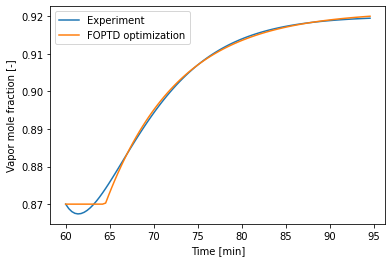

In [ ]:
z = foptd(ts,K,tau,t_d)
ypred = y[0] + z*(y[-1] - y[0])/100

plt.plot(t,y,t,ypred)
plt.xlabel('Time [min]')
plt.ylabel('Vapor mole fraction [-]')
plt.legend(['Experiment','FOPTD optimization'])